# Распознавание букв на пиксельных изображениях #

---
учебный проект по предмету Анализ неструктурированных данных

>  В данном проекте реализуется простая сверточная нейронная сеть (CNN) для классификации трёх букв латинского алфавита — K, Z и M. 

>  Используются собственноручно созданные изображения и их аугментация, чтобы компенсировать небольшой размер датасета. 

>  CNN обучается на этих данных, после чего оценивается на тестовом наборе и применяется для предсказания классов новых изображений.

Используемые библиотеки:

In [2]:
%%capture

import os
from PIL import Image # для открытия и обработки изображений
import numpy as np 
import tensorflow as tf # для построения модели
import matplotlib.pyplot as plt 
from keras.src.legacy.preprocessing.image import ImageDataGenerator # Класс из Keras для генерации аугментированных изображений во время обучения.

## Создание датасета

Буквы `K`, `Z` и `M` были выбранны для работы, так как в них присутствуют схожие графические элементы.

Для проекта был вручную создан датасет из изображений 32 на 32 пикселя с использованием ресурсов, предлагаемых онлайн-сервисом <https://www.piskelapp.com/>. 

Все изображения представлены в оттенках серого. 

Для повышения вариативности данных применяется аугментация: повороты, сдвиги, масштабирование и искажения.

### Обработка данных

In [3]:
IMG_WIDTH, IMG_HEIGHT = 32, 32    # Размер изображений (в пикселях)
LETTERS = ['K', 'Z', 'M']         # Распознаваемые символы
NUM_SAMPLES_PER_CLASS = 10        # Количество тренировочных изображений для каждого класса

In [4]:
data = []  # Список для хранения пикселей изображений
labels = []  # Список для хранения меток классов (0 — K, 1 — Z, 2 — M)

# Загрузка данных из директории dataset
for label_index, letter in enumerate(LETTERS):
    for i in range(1, NUM_SAMPLES_PER_CLASS + 1):
        image_path = f'dataset/{letter} ({i}).png'
        if not os.path.isfile(image_path):  # Проверка существования файла
            print(f"Warning: File {image_path} does not exist and will be skipped.")
            continue
        image = Image.open(image_path).convert('L')  # Преобразование в черно-белый формат
        numpydata = np.asarray(image).flatten()  # Преобразование изображения в одномерный массив
        data.append(numpydata)
        labels.append(label_index)  # Добавление метки класса

data = np.array(data)

### Генерация и визуализация аугментированных данных

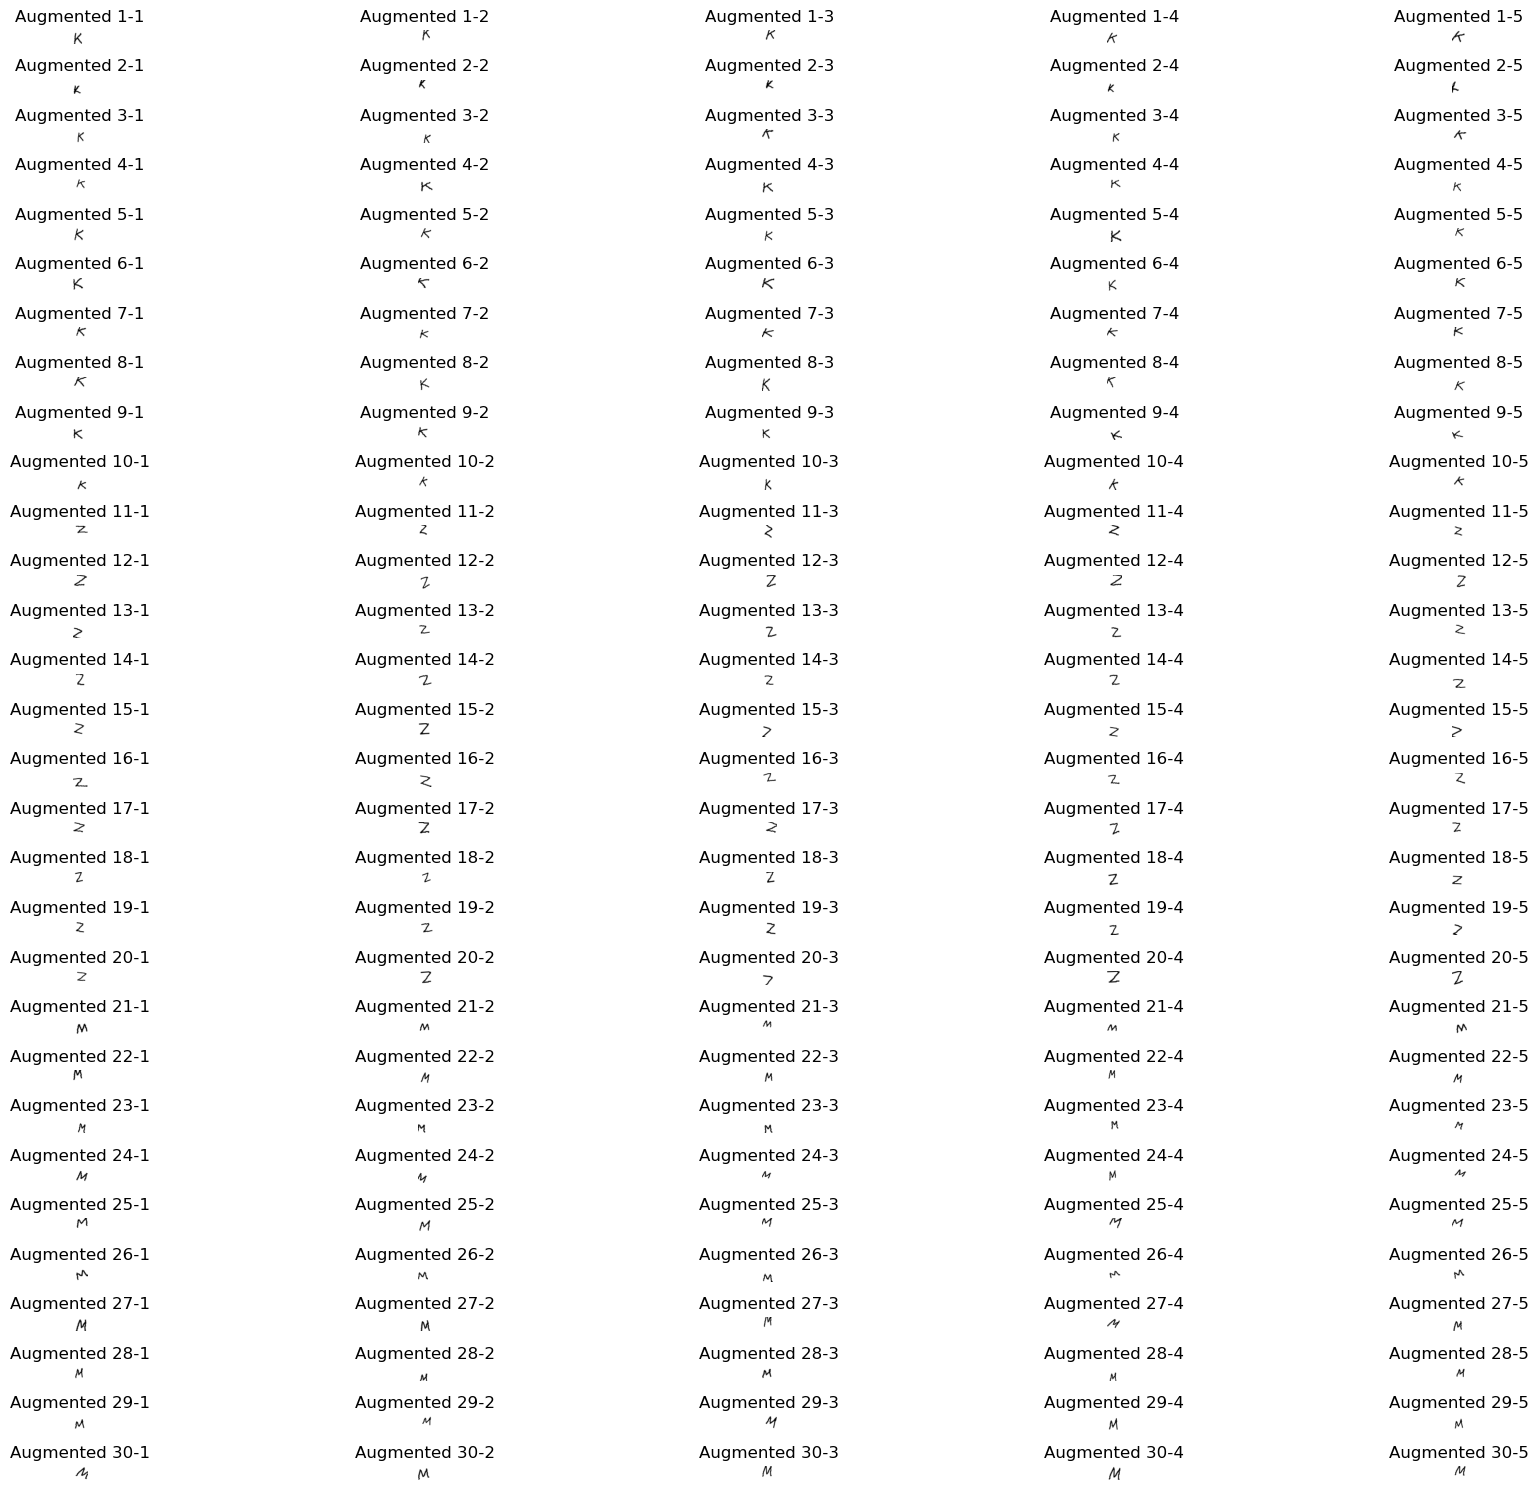

In [5]:
data_augmented = data.copy()
labels_augmented = labels.copy()

# Создание генератора аугментации данных
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    fill_mode='nearest'
)

num_augmented_samples = len(data_augmented)

# Генерация аугментированных данных и их визуализация
augmented_images = []
augmented_labels = []

plt.figure(figsize=(20, 15))

for i in range(num_augmented_samples):
    image_array = data_augmented[i:i + 1].reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1)  # Изменение формы для генератора

    # Генерируем 5 аугментированных изображений для каждого исходного
    for j in range(5):
        augmented_image_batch = next(datagen.flow(image_array, batch_size=1))
        augmented_image = augmented_image_batch[0].astype('uint8')
        augmented_images.append(augmented_image.flatten())
        augmented_labels.append(labels[i])
        
        # Визуализация аугментированного изображения
        plt.subplot(num_augmented_samples, 5, i * 5 + j + 1)
        plt.imshow(augmented_image.reshape(IMG_WIDTH, IMG_HEIGHT), cmap='gray')
        plt.axis('off')
        plt.title(f'Augmented {i+1}-{j+1}')


plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.tight_layout()
plt.show()


In [6]:
# Объединение оригинальных и аугментированных данных
X_combined = np.concatenate((data, augmented_images), axis=0)
Y_combined = np.concatenate((labels, augmented_labels), axis=0)

# Перемешивание объединённых данных
indices = np.arange(X_combined.shape[0])
np.random.shuffle(indices)
X_combined = X_combined[indices]
Y_combined = Y_combined[indices]

# Нормализация данных (значений пикселей) к диапазону [0, 1]
X_combined = X_combined.astype('float32') / 255.0 

# Деление данных (изображения из директории dataset + аугментированные данные) на обучающую (80%) и тестовую (20%) выборки
split_index = int(0.8 * len(X_combined))
X_train, X_test = X_combined[:split_index], X_combined[split_index:]
Y_train, Y_test = Y_combined[:split_index], Y_combined[split_index:]

## Архитектура модели

Строится простая `CNN`, состоящая из трёх сверточных блоков с слоями свёртки и подвыборки, после чего идут полносвязные слои с Dropout для регуляризации. Используется функция активации ReLU. Она помогает вводить нелинейность в модель и позволяет эффективно обрабатывать данные. Выходной слой с активацией `softmax` классифицирует изображение по трем классам.

In [7]:
%%capture

# Изменение формы входных данных для CNN
X_train = X_train.reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1)  # Добавление размерности для каналов (1 - черно-белое)
X_test = X_test.reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1)

model = tf.keras.models.Sequential() 
# Свёрточный слой
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 1)))
# Слой подвыборки
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Flatten())
# Полносвязный слой
model.add(tf.keras.layers.Dense(256, activation='relu'))
# Регуляризация с помощью Dropout
model.add(tf.keras.layers.Dropout(0.5))
# Выходной слой для трех классов
model.add(tf.keras.layers.Dense(len(LETTERS), activation='softmax'))

2025-06-04 17:10:08.052352: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## Обучение модели

Модель обучается 15 эпох с оптимизатором Adam и функцией потерь sparse_categorical_crossentropy,  
так как метки представлены как целые числа (0, 1, 2).

In [8]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=15, batch_size=8, validation_data=(X_test, Y_test))

Epoch 1/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.2923 - loss: 1.1125 - val_accuracy: 0.6111 - val_loss: 1.0543
Epoch 2/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5097 - loss: 1.0254 - val_accuracy: 0.5556 - val_loss: 0.8900
Epoch 3/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5545 - loss: 0.9176 - val_accuracy: 0.6667 - val_loss: 0.7412
Epoch 4/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8081 - loss: 0.5978 - val_accuracy: 0.8056 - val_loss: 0.4080
Epoch 5/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8186 - loss: 0.4493 - val_accuracy: 0.9167 - val_loss: 0.3427
Epoch 6/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9017 - loss: 0.2597 - val_accuracy: 0.9444 - val_loss: 0.1660
Epoch 7/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9377 - loss: 0.1456 - val_accuracy: 0.9167 - val_loss: 0.1446
Epoch 8/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9761 - loss: 0.0836 - val_accuracy: 0.9722 - v

## Оценка модели и визуализация результатов

После обучения модель проверяется на отложенном тестовом наборе. Строятся графики изменения `loss` и `accuracy` за эпохи, чтобы проанализировать качество обучения и наличие переобучения.

In [9]:
loss, accuracy = model.evaluate(X_test, Y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9711 - loss: 0.1034
Loss: 0.09980606287717819, Accuracy: 0.9722222089767456


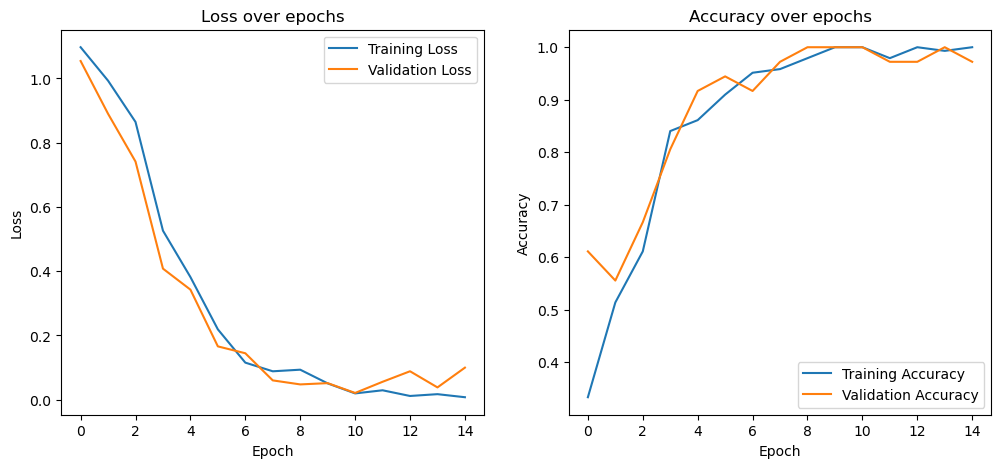

In [10]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Применение 

Обученная модель используется для предсказания классов букв на новых тестовых изображениях, которые загружаются из папки `test`.  

Результаты предсказаний визуализируются рядом с соответствующими изображениями.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


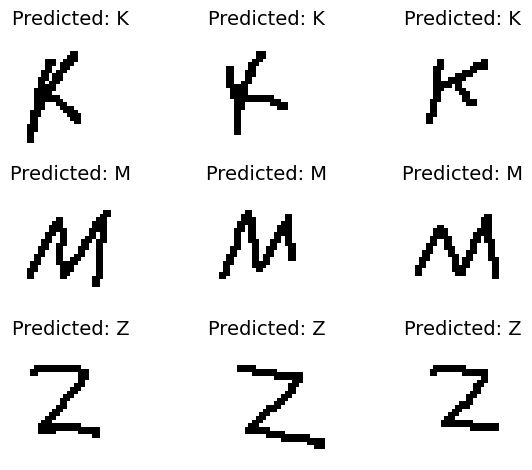

In [11]:
index = 1
while os.path.isfile(f"test/test_{index}.png"):
    img_path = f"test/test_{index}.png"
    img = Image.open(img_path).convert('L')  # Конвертируем в черно-белый формат
    img_resized = img.resize((IMG_WIDTH, IMG_HEIGHT))
    numpydata = np.asarray(img).flatten()    # Преобразуем изображение в одномерный массив
    # Нормализация 
    numpydata = numpydata.astype('float32') / 255.0  
    numpydata.shape = (1, IMG_WIDTH * IMG_HEIGHT)  # Изменение формы на (1, 1024)
    # Изменение формы для подачи в модель CNN
    numpydata_reshaped = numpydata.reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1)  
    # Получение предсказания
    prediction = model.predict(numpydata_reshaped)  
    match np.argmax(prediction): 
        case 0:
            result = 'K'
        case 1:
            result = 'Z'
        case 2:
            result = 'M'
        case _:
            result = "ERROR"
    plt.subplot(3, 3, index)
    plt.imshow(img_resized, cmap='gray')
    plt.title(f'Predicted: {result}', fontsize=14)
    plt.axis('off')
    index += 1

plt.tight_layout() 
plt.show()     

In [13]:
model.save('letter_recognition_model.h5') # сохранение модели
print("Model saved to letter_recognition_model.h5")

Model saved to letter_recognition_model.h5
